# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
!rm -rf assignment1
!wget http://cs231n.github.io/assignments/2018/spring1718_assignment1.zip
!unzip spring1718_assignment1.zip
!rm spring1718_assignment1.zip
!cd ./assignment1 && ls

--2018-12-04 16:01:41--  http://cs231n.github.io/assignments/2018/spring1718_assignment1.zip
Resolving cs231n.github.io (cs231n.github.io)... 185.199.110.153, 185.199.108.153, 185.199.109.153, ...
Connecting to cs231n.github.io (cs231n.github.io)|185.199.110.153|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73256 (72K) [application/zip]
Saving to: ‘spring1718_assignment1.zip’

spring1718_assignme 100%[===================>]  71.54K  --.-KB/s    in 0.02s   

2018-12-04 16:01:41 (2.93 MB/s) - ‘spring1718_assignment1.zip’ saved [73256/73256]

Archive:  spring1718_assignment1.zip
   creating: assignment1/
 extracting: assignment1/.gitignore  
   creating: assignment1/.ipynb_checkpoints/
  inflating: assignment1/.ipynb_checkpoints/features-checkpoint.ipynb  
  inflating: assignment1/.ipynb_checkpoints/knn-checkpoint.ipynb  
  inflating: assignment1/.ipynb_checkpoints/softmax-checkpoint.ipynb  
  inflating: assignment1/.ipynb_checkpoints/svm-checkpoint.ipynb  
  inf

In [2]:
!cd assignment1/cs231n/datasets && bash get_datasets.sh && ls

--2018-12-04 16:01:54--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  1.17MB/s    in 89s     

2018-12-04 16:03:24 (1.83 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1
cifar-10-batches-py  get_datasets.sh


In [0]:
cd assignment1

In [0]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [4]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [0]:
from __future__ import print_function

import numpy as np

class LinearClassifier(object):

  def __init__(self):
    self.W = None

  def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
            batch_size=200, verbose=False):
    """
    Train this linear classifier using stochastic gradient descent.

    Inputs:
    - X: A numpy array of shape (N, D) containing training data; there are N
      training samples each of dimension D.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c
      means that X[i] has label 0 <= c < C for C classes.
    - learning_rate: (float) learning rate for optimization.
    - reg: (float) regularization strength.
    - num_iters: (integer) number of steps to take when optimizing
    - batch_size: (integer) number of training examples to use at each step.
    - verbose: (boolean) If true, print progress during optimization.

    Outputs:
    A list containing the value of the loss function at each training iteration.
    """
    num_train, dim = X.shape
    num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes
    if self.W is None:
      # lazily initialize W
      self.W = 0.001 * np.random.randn(dim, num_classes)

    # Run stochastic gradient descent to optimize W
    loss_history = []
    for it in range(num_iters):
      index = np.random.choice(num_train, batch_size)
      X_batch = X[index,:]
      y_batch = y[index]

      # evaluate loss and gradient
      loss, grad = self.loss(X_batch, y_batch, reg)
      loss_history.append(loss)
      
      self.W -= learning_rate * grad

      if verbose and it % 100 == 0:
        print('iteration %d / %d: loss %f' % (it, num_iters, loss))

    return loss_history

  def predict(self, X):
    """
    Use the trained weights of this linear classifier to predict labels for
    data points.

    Inputs:
    - X: A numpy array of shape (N, D) containing training data; there are N
      training samples each of dimension D.

    Returns:
    - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
      array of length N, and each element is an integer giving the predicted
      class.
    """
    y_pred = np.zeros(X.shape[0])
    
    y_pred = np.argmax(np.dot(X, self.W),axis=1)
    
    return y_pred
  
  def loss(self, X_batch, y_batch, reg):
    """
    Compute the loss function and its derivative. 
    Subclasses will override this.

    Inputs:
    - X_batch: A numpy array of shape (N, D) containing a minibatch of N
      data points; each point has dimension D.
    - y_batch: A numpy array of shape (N,) containing labels for the minibatch.
    - reg: (float) regularization strength.

    Returns: A tuple containing:
    - loss as a single float
    - gradient with respect to self.W; an array of the same shape as W
    """
    pass


class LinearSVM(LinearClassifier):
  """ A subclass that uses the Multiclass SVM loss function """

  def loss(self, X_batch, y_batch, reg):
    return svm_loss_vectorized(self.W, X_batch, y_batch, reg)


class Softmax(LinearClassifier):
  """ A subclass that uses the Softmax + Cross-entropy loss function """

  def loss(self, X_batch, y_batch, reg):
    return softmax_loss_vectorized(self.W, X_batch, y_batch, reg)



In [0]:
import numpy as np
from random import shuffle

def softmax_loss_naive(W, X, y, reg):
  """
  Softmax loss function, naive implementation (with loops)

  Inputs have dimension D, there are C classes, and we operate on minibatches
  of N examples.

  Inputs:
  - W: A numpy array of shape (D, C) containing weights.
  - X: A numpy array of shape (N, D) containing a minibatch of data.
  - y: A numpy array of shape (N,) containing training labels; y[i] = c means
    that X[i] has label c, where 0 <= c < C.
  - reg: (float) regularization strength

  Returns a tuple of:
  - loss as single float
  - gradient with respect to weights W; an array of same shape as W
  """
  # Initialize the loss and gradient to zero.
  loss = 0.0
  dW = np.zeros_like(W)
  num_train = X.shape[0]
  num_classes = W.shape[1]
  
  for i in range(num_train):
    z = np.dot(X[i], W)    
    
    z -= np.max(z)
    prob = np.exp(z) / np.sum(np.exp(z))
    loss += -np.log(prob[y[i]])

    prob[y[i]] -= 1
    
    # dW is adjusted by each row being the X[i] pixel values by the probability vector
    for j in range(num_classes):
      dW[:,j] += X[i,:] * prob[j]

  # Right now the loss is a sum over all training examples, but we want it
  # to be an average instead so we divide by num_train.
  loss /= num_train
  dW /= num_train

  # Add regularization to the loss.
  loss += 0.5 * reg * np.sum(W * W)
  dW += reg * W

  return loss, dW


def softmax_loss_vectorized(W, X, y, reg):
  """
  Softmax loss function, vectorized version.

  Inputs and outputs are the same as softmax_loss_naive.
  """
  # Initialize the loss and gradient to zero.
  loss = 0.0
  dW = np.zeros_like(W)
  num_train = X.shape[0]
  num_classes = W.shape[1]
  
  h = np.dot(X, W)
  
  h -= np.max(h, axis=1, keepdims=True)
  
  prob = np.divide(np.exp(h), np.sum(np.exp(h), axis=1, keepdims=True))
  
  true_class = prob[range(num_train), y]
  loss = np.sum(-np.log(true_class)) / num_train
  loss += 0.5 * reg * np.sum(W * W)
  
  prob[range(num_train),y] -= 1
  dW = np.dot(X.T, prob) / num_train
  
  return loss, dW



In [7]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.436867
sanity check: 2.302585


In [8]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -1.799612 analytic: -1.799612, relative error: 4.915896e-09
numerical: 1.766789 analytic: 1.766789, relative error: 3.243037e-08
numerical: 4.216894 analytic: 4.216894, relative error: 3.087078e-08
numerical: 3.695665 analytic: 3.695665, relative error: 2.606611e-08
numerical: -4.420023 analytic: -4.420023, relative error: 1.650715e-08
numerical: -0.473175 analytic: -0.473175, relative error: 5.673808e-08
numerical: 0.254510 analytic: 0.254510, relative error: 5.627301e-08
numerical: -0.483721 analytic: -0.483721, relative error: 1.840352e-08
numerical: 2.470015 analytic: 2.470015, relative error: 1.796566e-08
numerical: 0.138051 analytic: 0.138051, relative error: 5.751440e-07
numerical: 2.295791 analytic: 2.295791, relative error: 3.693785e-09
numerical: 1.604369 analytic: 1.604369, relative error: 3.235794e-08
numerical: -0.652510 analytic: -0.652511, relative error: 1.034087e-07
numerical: 2.940689 analytic: 2.940689, relative error: 9.077186e-09
numerical: 0.130640 anal

In [9]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.436867e+00 computed in 0.186372s
vectorized loss: 2.436867e+00 computed in 0.015301s
Loss difference: 0.000000
Gradient difference: 0.000000


In [10]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-5, 1e-6, 1e-7]
regularization_strengths = [0.5e4, 2.5e4, 5e4]

for i in learning_rates:
  for j in regularization_strengths:
    sftmx = Softmax()
    tic = time.time()
    sftmx.train(X_train, y_train, learning_rate=i, reg=j,
                      num_iters=1500, verbose=False)
    toc = time.time()
    print('That took %fs' % (toc-tic))
    
    train_acc = np.mean(sftmx.predict(X_train) == y_train)
    val_acc = np.mean(sftmx.predict(X_val) == y_val)
    
    if val_acc > best_val:
      best_val = val_acc
      best_softmax = sftmx
      
    results[(i,j)] = (train_acc, val_acc) 

That took 9.666153s
That took 9.713369s
That took 9.661583s
That took 9.675625s
That took 9.665001s
That took 9.689334s
That took 9.714590s
That took 9.748842s
That took 9.686148s


In [11]:
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-07 reg 5.000000e+03 train accuracy: 0.247714 val accuracy: 0.247000
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.253429 val accuracy: 0.220000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.246714 val accuracy: 0.245000
lr 1.000000e-06 reg 5.000000e+03 train accuracy: 0.351449 val accuracy: 0.341000
lr 1.000000e-06 reg 2.500000e+04 train accuracy: 0.349755 val accuracy: 0.336000
lr 1.000000e-06 reg 5.000000e+04 train accuracy: 0.346837 val accuracy: 0.349000
lr 1.000000e-05 reg 5.000000e+03 train accuracy: 0.301102 val accuracy: 0.300000
lr 1.000000e-05 reg 2.500000e+04 train accuracy: 0.326000 val accuracy: 0.319000
lr 1.000000e-05 reg 5.000000e+04 train accuracy: 0.362612 val accuracy: 0.357000
best validation accuracy achieved during cross-validation: 0.357000


In [12]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.342000


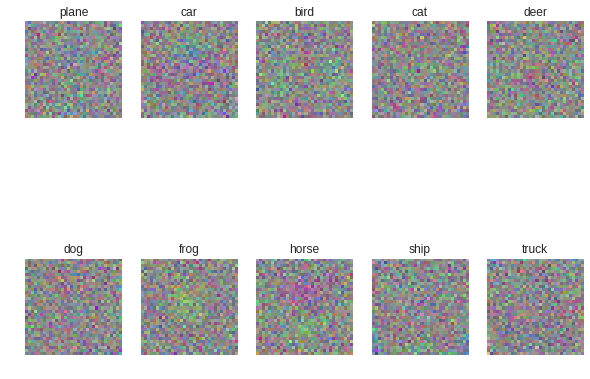

In [13]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])